# Flight Price Prediction

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [19]:
# Load the dataset
data = pd.read_csv("C:/Shrutika/UT Dallas/Classes/4 - Fall 2024/Applied Machine Learning/Project/Clean_Dataset.csv")

In [20]:
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


(   ID   airline   flight source_city departure_time stops   arrival_time  \
 0   0  SpiceJet  SG-8709       Delhi        Evening  zero          Night   
 1   1  SpiceJet  SG-8157       Delhi  Early_Morning  zero        Morning   
 2   2   AirAsia   I5-764       Delhi  Early_Morning  zero  Early_Morning   
 3   3   Vistara   UK-995       Delhi        Morning  zero      Afternoon   
 4   4   Vistara   UK-963       Delhi        Morning  zero        Morning   
 
   destination_city    class  duration  days_left  price  
 0           Mumbai  Economy      2.17          1   5953  
 1           Mumbai  Economy      2.33          1   5953  
 2           Mumbai  Economy      2.17          1   5956  
 3           Mumbai  Economy      2.25          1   5955  
 4           Mumbai  Economy      2.33          1   5955  ,
 None)

In [23]:
pd.options.mode.copy_on_write = True # Allow re-write on variable
warnings.filterwarnings('ignore') # Ignore warnings
pd.set_option('display.max_columns', None) # Setting this option will print all columns of a dataframe
pd.set_option('display.max_colwidth', None) # Setting this option will print all of the data in a feature

In [25]:
# Dropping irrelevant columns
data_cleaned = data.drop(columns=['ID', 'flight'])
data_cleaned.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [27]:
# Label Encoding for categorical features
label_encoded_data = data_cleaned.copy()
label_encoders = {}
categorical_columns = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']

for col in categorical_columns:
    le = LabelEncoder()
    label_encoded_data[col] = le.fit_transform(data_cleaned[col])
    label_encoders[col] = le

In [28]:
# One-Hot Encoding for categorical features
one_hot_encoded_data = pd.get_dummies(data_cleaned, columns=categorical_columns, drop_first=True)

In [31]:
# Splitting the data
X_label_encoded = label_encoded_data.drop(columns=['price'])
y = label_encoded_data['price']
X_one_hot_encoded = one_hot_encoded_data.drop(columns=['price'])

# Train-test split
X_train_label, X_test_label, y_train, y_test = train_test_split(X_label_encoded, y, test_size=0.2, random_state=42)
X_train_one_hot, X_test_one_hot, _, _ = train_test_split(X_one_hot_encoded, y, test_size=0.2, random_state=42)

# Confirm preprocessing steps
X_train_label.head(), X_train_one_hot.head()

(        airline  source_city  departure_time  stops  arrival_time  \
 148417        1            4               0      0             4   
 36879         3            2               0      1             5   
 274531        1            4               0      0             0   
 166397        5            3               5      0             1   
 272722        5            4               5      0             5   
 
         destination_city  class  duration  days_left  
 148417                 1      1     19.42          6  
 36879                  1      1      7.00         13  
 274531                 1      0     21.17         44  
 166397                 0      1     10.25         11  
 272722                 1      0     26.50          5  ,
         duration  days_left  airline_Air_India  airline_GO_FIRST  \
 148417     19.42          6               True             False   
 36879       7.00         13              False             False   
 274531     21.17         44      

## KNN MODEL

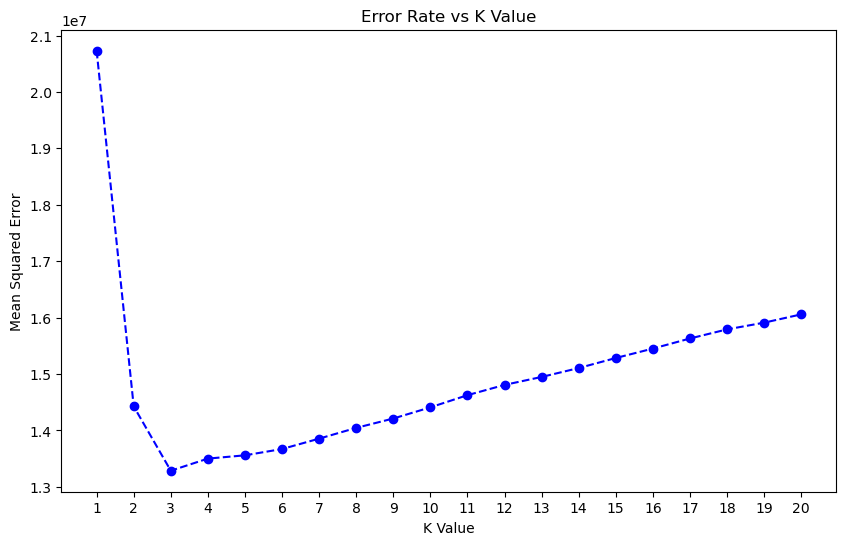

Best K value: 3
Mean Absolute Error (MAE): 1670.23
Mean Squared Error (MSE): 13286741.25
Root Mean Squared Error (RMSE): 3645.10
R² Score: 0.97

Too small K (e.g., K=1) can lead to overfitting, where the model is very sensitive to noise in the data.
Too large K can cause underfitting, where the model becomes too generalized and loses important details. This is why the best K value is 3. 



In [21]:
# Standardize the features for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_label)
X_test_scaled = scaler.transform(X_test_label)

# Choosing the best K using cross-validation
error_rates = []
for k in range(1, 21):  
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_k = knn.predict(X_test_scaled)
    error = mean_squared_error(y_test, y_pred_k)
    error_rates.append(error)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), error_rates, marker='o', linestyle='--', color='b')
plt.title('Error Rate vs K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Squared Error')
plt.xticks(range(1, 21))
plt.show()

# Train the KNN model with the best K value 
best_k = error_rates.index(min(error_rates)) + 1 
print(f"Best K value: {best_k}")

knn_model = KNeighborsRegressor(n_neighbors=best_k)
knn_model.fit(X_train_scaled, y_train)

# Predicting the prices on the test set
y_pred = knn_model.predict(X_test_scaled)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

print("""
Too small K (e.g., K=1) can lead to overfitting, where the model is very sensitive to noise in the data.
Too large K can cause underfitting, where the model becomes too generalized and loses important details. This is why the best K value is 3. 
""")

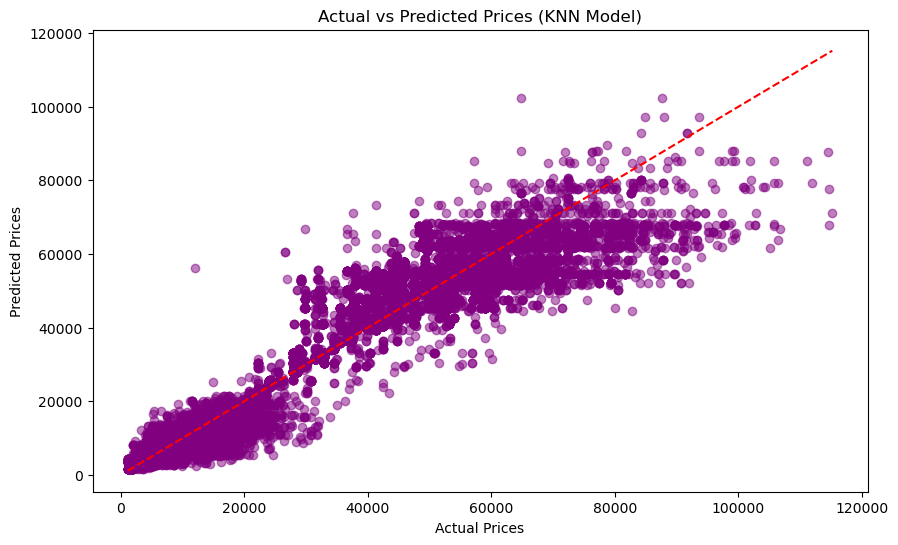

In [23]:
# Visualizing Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted Prices (KNN Model)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

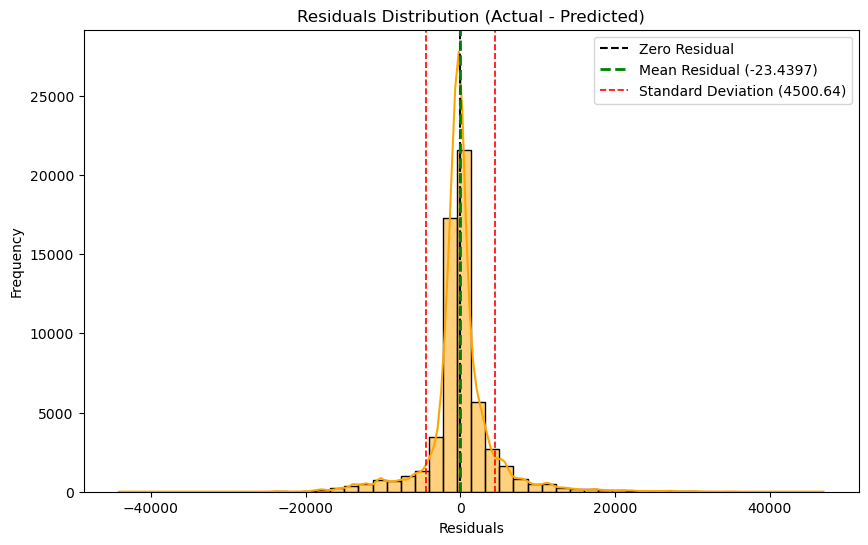


Centered Residuals: If the mean line is close to zero, it indicates that the model does not systematically overestimate or underestimate predictions.
Spread: A narrower spread (standard deviation lines close to the center) indicates lower error variability, while a wider spread suggests higher error variability.
Shape: Ideally, the residuals should follow a normal distribution (bell-shaped curve) centered around zero, indicating a well-fitting model.



In [25]:
# Calculate residuals
knn_residuals = y_test - y_pred  

# Residuals Plot
plt.figure(figsize=(10, 6))
sns.histplot(knn_residuals, kde=True, color='orange', bins=50)  
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Zero Residual')
plt.axvline(x=knn_residuals.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean Residual ({knn_residuals.mean():.4f})')
plt.axvline(x=knn_residuals.std(), color='red', linestyle='--', linewidth=1.2, label=f'Standard Deviation ({knn_residuals.std():.2f})')
plt.axvline(x=-knn_residuals.std(), color='red', linestyle='--', linewidth=1.2)

# Adding labels and title
plt.title('Residuals Distribution (Actual - Predicted)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Insights
print("""
Centered Residuals: If the mean line is close to zero, it indicates that the model does not systematically overestimate or underestimate predictions.
Spread: A narrower spread (standard deviation lines close to the center) indicates lower error variability, while a wider spread suggests higher error variability.
Shape: Ideally, the residuals should follow a normal distribution (bell-shaped curve) centered around zero, indicating a well-fitting model.
""")

## DECISION TREE

In [33]:
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_model.fit(X_train_label, y_train)

# Predicting the prices on the test set
y_trainpred = dt_model.predict(X_train_label)
y_pred = dt_model.predict(X_test_label)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
train_r2 = r2_score(y_train, y_trainpred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Test R² Score: {r2:.2f}")
print(f"Training R² Score: {train_r2:.2f}")
print(f"Number of Leaves: {dt_model.get_n_leaves()}")

Mean Absolute Error (MAE): 2518.45
Mean Squared Error (MSE): 20255930.09
Root Mean Squared Error (RMSE): 4500.66
Test R² Score: 0.96
Training R² Score: 0.96
Number of Leaves: 874


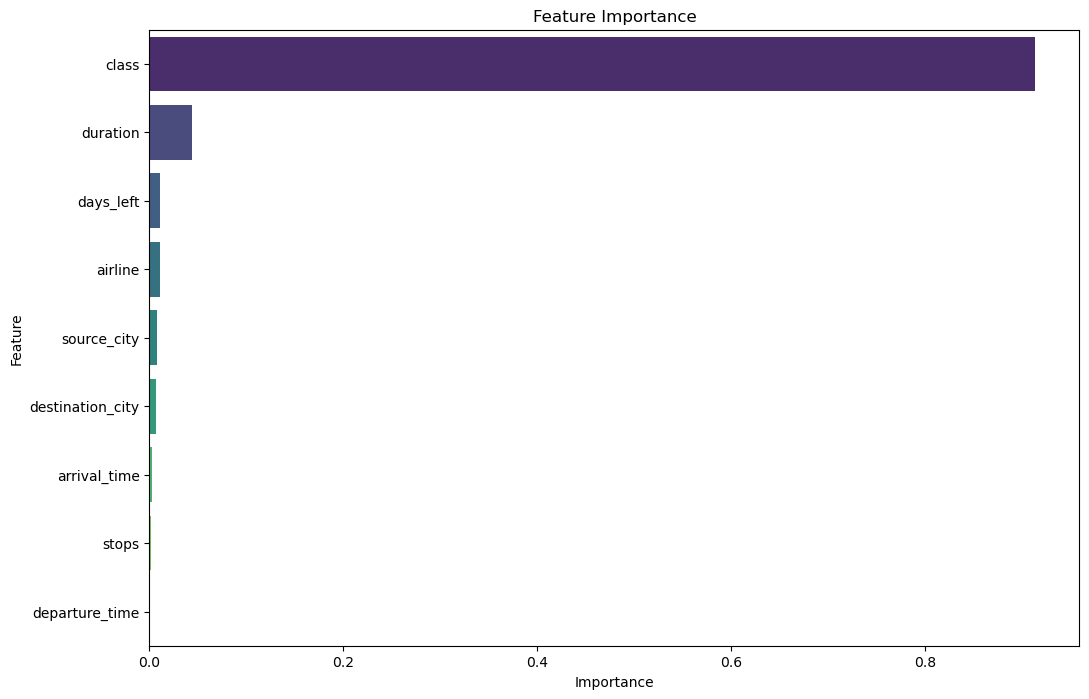

In [34]:
# Feature Importance Visualization
feature_importance = pd.DataFrame({
    'Feature': X_train_label.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Important Features: Index(['class'], dtype='object')


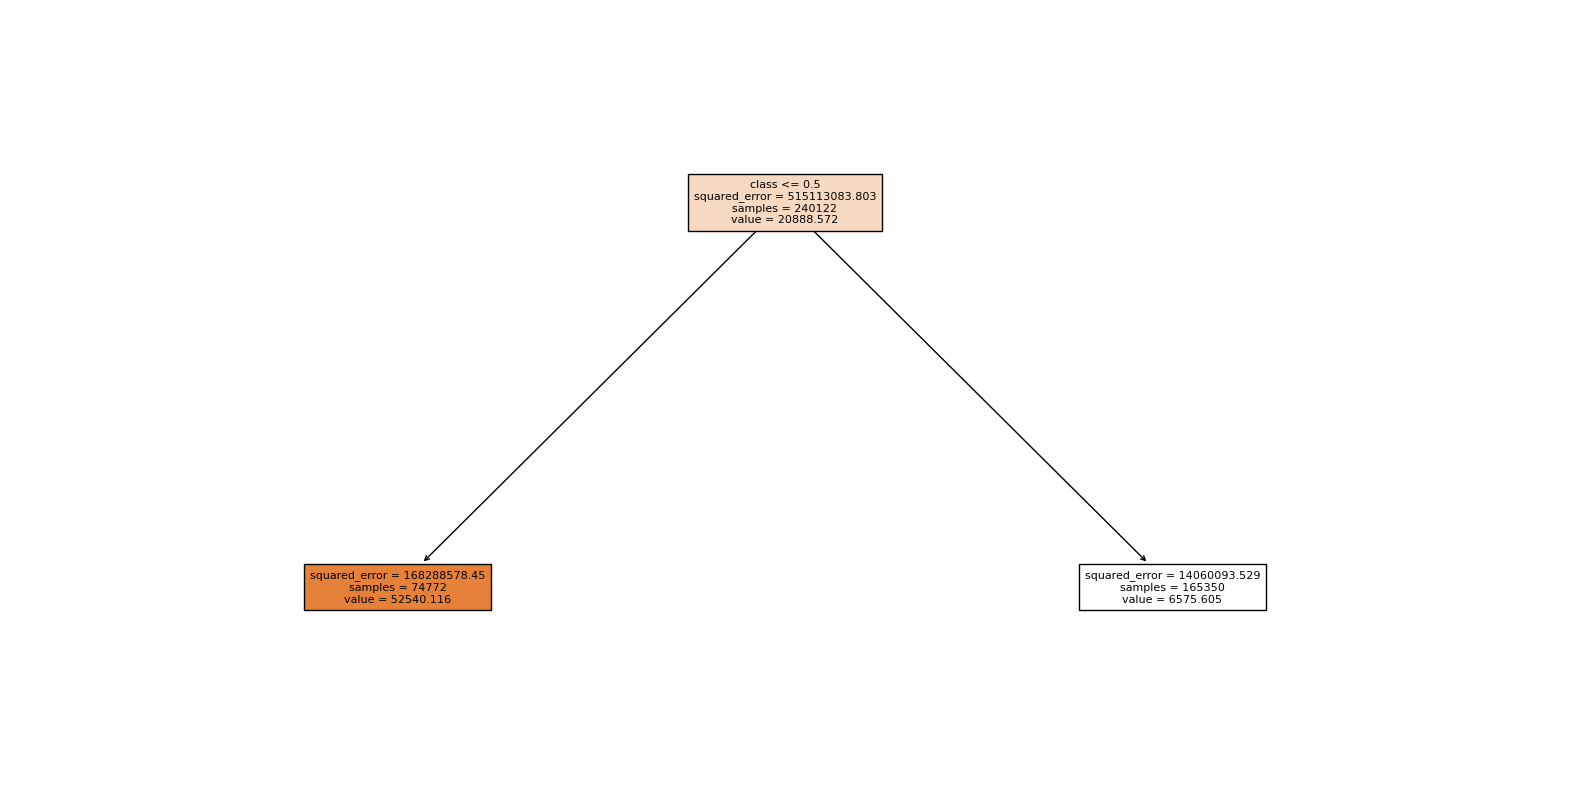

In [69]:
# Decision Tree visualization

feature_importances = dt_model.feature_importances_

# Select features with feature importance > 0.05
important_features = X_label_encoded.columns[feature_importances > 0.05]
print(f"Important Features: {important_features}")

# Only important features
X_train_important = X_train_label[important_features]
X_test_important = X_test_label[important_features]

# Decision Tree model using only important features
model_important = DecisionTreeRegressor(max_depth=10)
model_important.fit(X_train_important, y_train)

# Plotting new decision tree
plt.figure(figsize=(20, 10))
plot_tree(model_important, 
          filled=True, 
          feature_names=important_features, 
          class_names=[str(c) for c in y_train.unique()],  # Adjust class names if needed
          fontsize=8)  # Adjust font size for readability
          
plt.show()

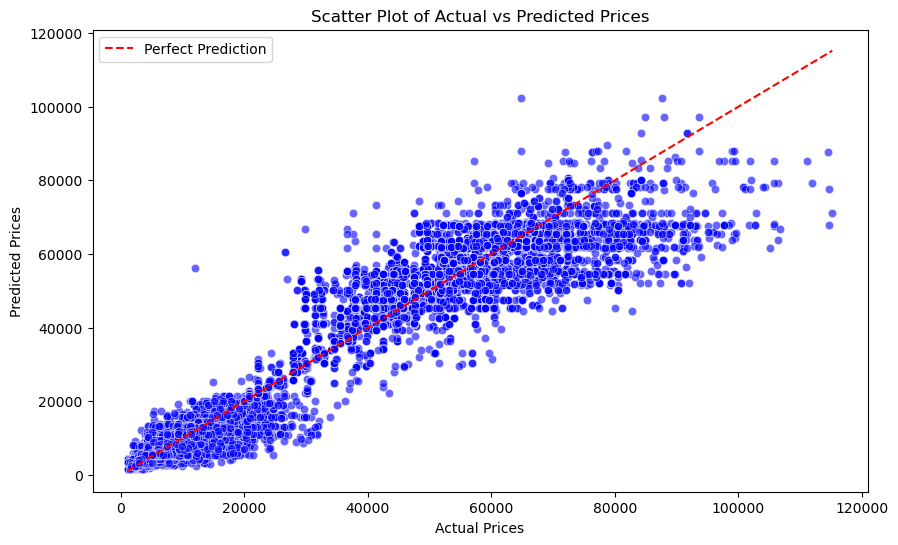

In [35]:
# Scatter Plot: Actual vs Predicted Prices
plt.figure(figsize=(10, 6))

# Plotting the scatter plot
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.6)

# Plotting the reference line (y = x) for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=1.5, label='Perfect Prediction')

# Adding labels and title
plt.title('Scatter Plot of Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.show()

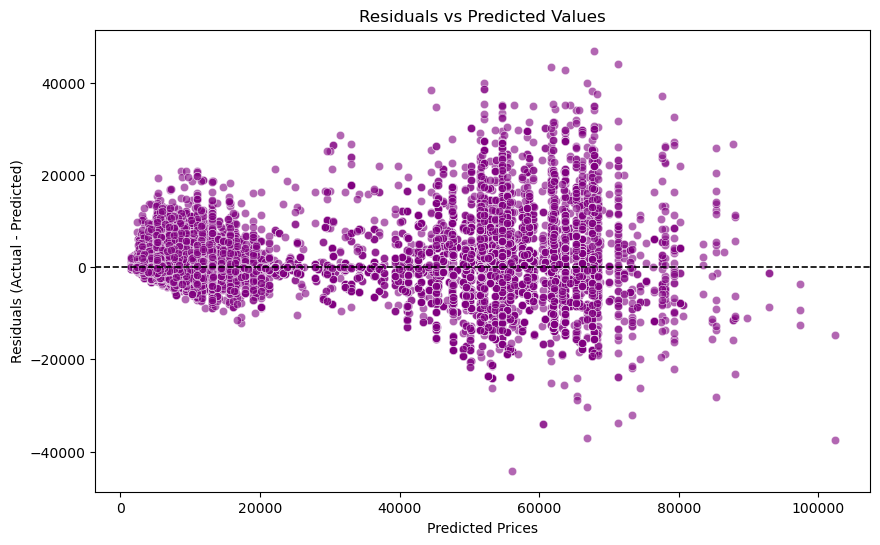

In [36]:
# Residuals vs Predicted Values
dt_residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=dt_residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.2)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

## LINEAR REGRESSION

In [47]:
# LINEAR REGRESSION 

# Identify categorical columns for one-hot encoding
categorical_cols = X_one_hot_encoded.select_dtypes(include=['object']).columns

# Set up a column transformer for one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Keep other numeric columns as they are
)

# Define hyperparameter grid for Ridge and Lasso
param_grid = {'alpha': np.logspace(-3, 3, 5)}  # Alpha values from 0.001 to 1000

# Build pipelines for Ridge and Lasso
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso(max_iter=10000))
])

# Initialize GridSearchCV for Ridge and Lasso
ridge_grid_search = GridSearchCV(ridge_pipeline, {'ridge__alpha': np.logspace(-3, 3, 5)}, scoring='r2', cv=5, n_jobs=-1)
lasso_grid_search = GridSearchCV(lasso_pipeline, {'lasso__alpha': np.logspace(-3, 3, 5)}, scoring='r2', cv=5, n_jobs=-1)

# Fit the models using Grid Search
ridge_grid_search.fit(X_train_one_hot, y_train)
lasso_grid_search.fit(X_train_one_hot, y_train)

# Get the best parameters for Ridge and Lasso
best_ridge_alpha = ridge_grid_search.best_params_['ridge__alpha']
best_lasso_alpha = lasso_grid_search.best_params_['lasso__alpha']

print(f"Best Ridge Alpha: {best_ridge_alpha}")
print(f"Best Lasso Alpha: {best_lasso_alpha}")

# Predict on the test set
ridge_pred = ridge_grid_search.predict(X_test_one_hot)
lasso_pred = lasso_grid_search.predict(X_test_one_hot)

# Evaluate the optimized models
ridge_rmse = mean_squared_error(y_test, ridge_pred, squared=False)
ridge_r2 = r2_score(y_test, ridge_pred)

lasso_rmse = mean_squared_error(y_test, lasso_pred, squared=False)
lasso_r2 = r2_score(y_test, lasso_pred)

print(f"Ridge RMSE: {ridge_rmse:}, Ridge R2: {ridge_r2:}")
print(f"Lasso RMSE: {lasso_rmse:}, Lasso R2: {lasso_r2:}")

Best Ridge Alpha: 1.0
Best Lasso Alpha: 0.001
Ridge RMSE: 6761.712735905488, Ridge R2: 0.9113048857987591
Lasso RMSE: 6761.7136253088665, Lasso R2: 0.9113048624656946


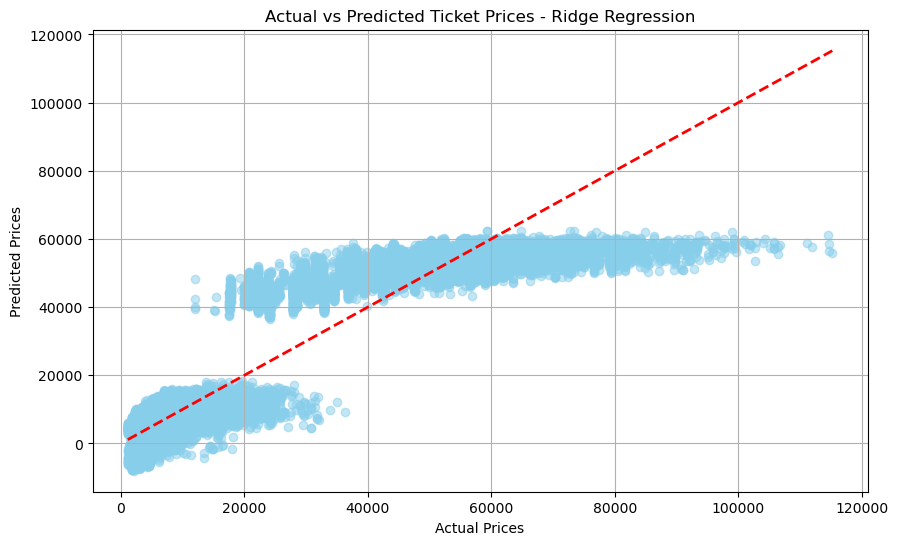

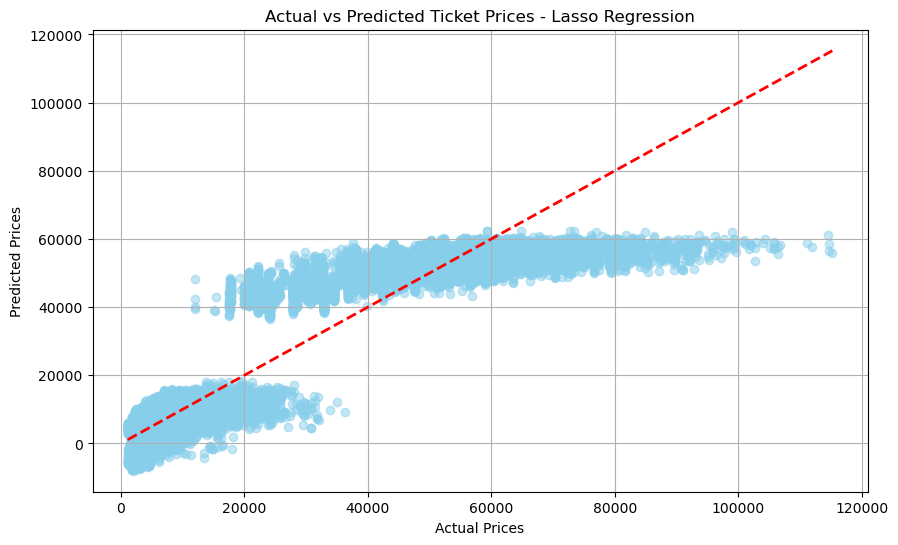

In [48]:
# Plotting function for actual vs predicted values
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color='skyblue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'Actual vs Predicted Ticket Prices - {model_name}')
    plt.grid(True)
    plt.show()

# Visualize Actual vs Predicted for Ridge
plot_actual_vs_predicted(y_test, ridge_pred, model_name='Ridge Regression')

# Visualize Actual vs Predicted for Lasso
plot_actual_vs_predicted(y_test, lasso_pred, model_name='Lasso Regression')

Gradient Boosting (One-Hot Encoded) - RMSE: 5001.12, R2: 0.95


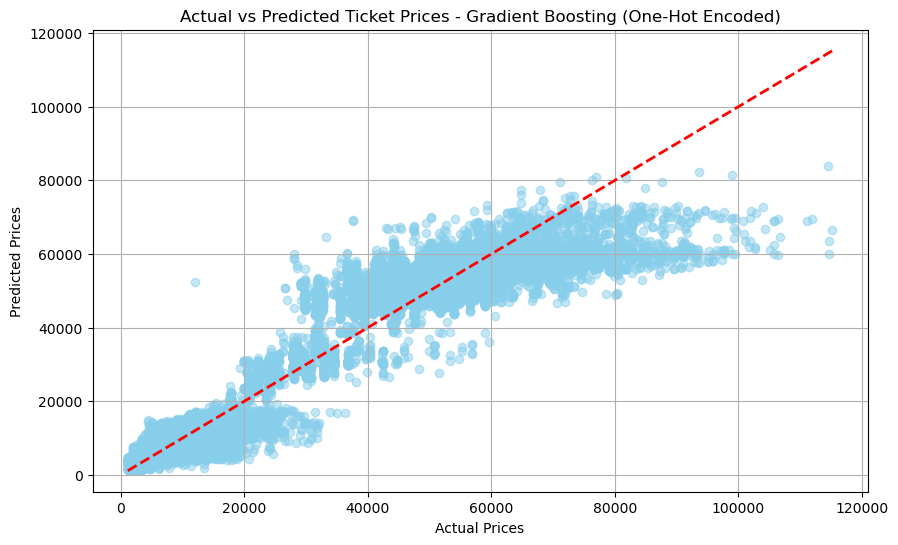

In [35]:
# Gradient Boosting Regressor for One-Hot Encoded data
gbr_one_hot = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Train Gradient Boosting on One-Hot Encoded data
gbr_one_hot.fit(X_train_one_hot, y_train)

# Predict for One-Hot Encoded data
y_pred_one_hot = gbr_one_hot.predict(X_test_one_hot)

# Evaluate One-Hot Encoded Model
rmse_one_hot = mean_squared_error(y_test, y_pred_one_hot, squared=False)
r2_one_hot = r2_score(y_test, y_pred_one_hot)

# Print performance metrics
print(f"Gradient Boosting (One-Hot Encoded) - RMSE: {rmse_one_hot:.2f}, R2: {r2_one_hot:.2f}")

# Plotting Actual vs Predicted
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color='skyblue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'Actual vs Predicted Ticket Prices - {model_name}')
    plt.grid(True)
    plt.show()

# Plot for One-Hot Encoded data
plot_actual_vs_predicted(y_test, y_pred_one_hot, model_name='Gradient Boosting (One-Hot Encoded)')

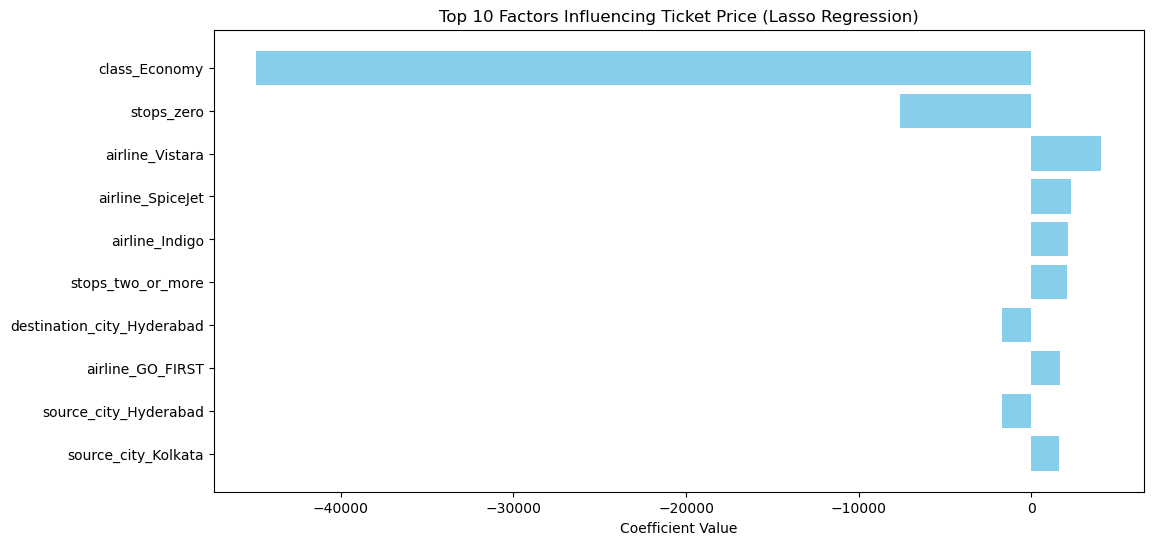

In [49]:
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt

# Re-initialize Lasso with the best alpha value found from GridSearchCV
lasso_model = Lasso(alpha=best_lasso_alpha, max_iter=10000)
lasso_model.fit(X_train_one_hot, y_train)

# Extract feature coefficients from the fitted Lasso model
lasso_coefficients = lasso_model.coef_

# Get the feature names after One-Hot Encoding 
encoded_feature_names = X_train_one_hot.columns

# Combine the encoded feature names with the original numerical feature names
numerical_feature_names = X_train_label.drop(columns=categorical_columns).columns
all_feature_names = list(encoded_feature_names) + list(numerical_feature_names)

# Sort coefficients by absolute value for better visualization
sorted_indices = np.argsort(np.abs(lasso_coefficients))[::-1]
sorted_features = np.array(all_feature_names)[sorted_indices]
sorted_coefficients = lasso_coefficients[sorted_indices]

# Visualize top 10 influencing factors
plt.figure(figsize=(12, 6))
plt.barh(sorted_features[:10], sorted_coefficients[:10], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Top 10 Factors Influencing Ticket Price (Lasso Regression)')
plt.gca().invert_yaxis()
plt.show()
